In [ ]:
import pandas as pd
import numpy as np
from PIL import Image
import os

def load_mnist_from_folder(folder, label_csv):
    df = pd.read_csv(label_csv)
    images = []
    labels = []
    for _, row in df.iterrows():
        img_path = os.path.join(folder, row["filename"])
        img = Image.open(img_path).convert("L")
        img = np.array(img).reshape(28, 28, 1).astype("float32") / 255.0
        images.append(img)
        labels.append(int(row["label"]))
    return np.array(images), np.array(labels)

# Load ảnh và nhãn từ thư mục MNIST
x_mnist_train, y_mnist_train = load_mnist_from_folder(r"F:\DAKHMT\CLone\Hand-Written\datas\mnist_dataset\train", r"F:\DAKHMT\CLone\Hand-Written\datas\mnist_dataset\train_labels.csv")
x_mnist_test, y_mnist_test = load_mnist_from_folder(r"F:\DAKHMT\CLone\Hand-Written\datas\mnist_dataset\test", r"F:\DAKHMT\CLone\Hand-Written\datas\mnist_dataset\test_labels.csv")

# Gộp train/test
x_mnist = np.concatenate([x_mnist_train, x_mnist_test], axis=0)
y_mnist = np.concatenate([y_mnist_train, y_mnist_test], axis=0)


In [ ]:
#load data A-Z từ file csv
df_az = pd.read_csv(r'F:\DAKHMT\CLone\Hand-Written\datas\A_Z Handwritten Data.csv')

X_az = df_az.drop("0", axis=1).values.reshape(-1, 28, 28, 1).astype("float32") / 255.0
y_az = df_az["0"].values.astype(np.int32) + 10  # A=10, B=11, ..., Z=35

In [ ]:
# Gộp dữ liệu MNIST và A-Z
X = np.concatenate([x_mnist, X_az], axis=0)
y = np.concatenate([y_mnist, y_az], axis=0)


In [ ]:
# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

num_classes = 36
y_cat = to_categorical(y, num_classes)

X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.1, random_state=42)


In [ ]:
# Tạo mô hình CNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(28,28,1)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),

    Conv2D(64, kernel_size=(3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(36, activation='softmax')  # 0–9, A–Z = 36 lớp
])

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Huấn luyện mô hình
model.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_test, y_test))

Epoch 1/10
3111/3111 [==============================] - 253s 81ms/step - loss: 0.4585 - accuracy: 0.8702 - val_loss: 0.1257 - val_accuracy: 0.9634
Epoch 2/10
3111/3111 [==============================] - 249s 80ms/step - loss: 0.2211 - accuracy: 0.9359 - val_loss: 0.0927 - val_accuracy: 0.9736
Epoch 3/10
3111/3111 [==============================] - 238s 76ms/step - loss: 0.1841 - accuracy: 0.9471 - val_loss: 0.0843 - val_accuracy: 0.9757
Epoch 4/10
3111/3111 [==============================] - 240s 77ms/step - loss: 0.1642 - accuracy: 0.9529 - val_loss: 0.0770 - val_accuracy: 0.9780
Epoch 5/10
3111/3111 [==============================] - 240s 77ms/step - loss: 0.1505 - accuracy: 0.9562 - val_loss: 0.0714 - val_accuracy: 0.9797
Epoch 6/10
3111/3111 [==============================] - 239s 77ms/step - loss: 0.1403 - accuracy: 0.9594 - val_loss: 0.0656 - val_accuracy: 0.9808
Epoch 7/10
3111/3111 [==============================] - 231s 74ms/step - loss: 0.1328 - accuracy: 0.9614 - val_loss: 0

In [ ]:
# Lưu mô hình
model.save("model_char_digit_36class.h5")

f:\DAKHMT\CLone\Hand-Written\.venv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Tải mô hình đã lưu và dự đoán
from tensorflow.keras.models import load_model
from PIL import Image, ImageOps
import numpy as np
import matplotlib.pyplot as plt

# Bản đồ nhãn
word_dict = {i: str(i) for i in range(10)}
word_dict.update({i + 10: chr(ord('A') + i) for i in range(26)})

# Tiền xử lý ảnh mới
def preprocess_image(image_path):
    img = Image.open(image_path).convert("L")
    img = ImageOps.invert(img)
    img.thumbnail((20, 20), Image.LANCZOS)
    new_img = Image.new('L', (28, 28), color=0)
    upper_left = ((28 - img.width) // 2, (28 - img.height) // 2)
    new_img.paste(img, upper_left)
    img_array = np.array(new_img).astype("float32") / 255.0
    return img_array.reshape(1, 28, 28, 1), new_img

# Dự đoán và hiển thị
def predict_and_show(model, image_path):
    img_array, processed_img = preprocess_image(image_path)
    prediction = model.predict(img_array)
    label_index = np.argmax(prediction)
    label_char = word_dict[label_index]

    plt.imshow(processed_img, cmap='gray')
    plt.title(f"Dự đoán: {label_char} (label: {label_index})")
    plt.axis('off')
    plt.show()

    return label_index, label_char


1/1 [==============================] - 0s 96ms/step


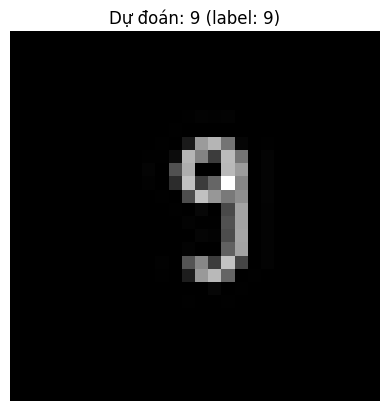

(9, '9')

In [ ]:
# Tải mô hình đã lưu và dự đoán
model = load_model("model_char_digit_36class.h5")
predict_and_show(model, r'F:\DAKHMT\CLone\vietnamese_chars_dataset\a\a_010.png')
 